In [3]:
import pandas as pd                                    # Working with tables
import numpy as np

from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'349dd4117e5d1ed71a22f0207a8e439cf3f7b06b'})
quandl.ApiConfig.api_key = '_ci7hzC_sPkspKWz2yzt'                      # Replace the XXXX with your API key (must be inside the ' ').

import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice.
%matplotlib inline

# Here are a bunch of functions I made, and how to use them

First, I made functions that return the basic stats we will need to do the analysis. When using them, you must enter the tickers and start and end dates as arguments. For the rest of the analysis to work, you need to define each of these stats as a variable when you use these functions, and the variable name **cannot** be the same as the function name. For example, to find returns you could write:
``` 
r = returns(tickers,start_date,end_date)
```


In [4]:
#make functions for all of the major stats so that I can just put the tickers in to make things easier


def returns(tickers,start_date,end_date):
    from tiingo import TiingoClient  
    # first pull the data you need from tiingo
    tiingo = TiingoClient({'api_key':'349dd4117e5d1ed71a22f0207a8e439cf3f7b06b'})
    prices  = tiingo.get_dataframe(tickers, start_date, end_date, metric_name='adjClose')
    prices.index = pd.to_datetime(prices.index).tz_convert(None) 
    #bring in SPY now just because this is where we are getting our data
    spy = tiingo.get_dataframe('SPY', '2016-3-8', metric_name='adjClose')
    spy.index = pd.to_datetime(spy.index).tz_convert(None)
    
    #find the returns of the tickers in prices
    r = prices.pct_change()
    
    return r
    
def rp(tickers,start_date,end_date):
    # first pull the data you need from tiingo
    prices  = tiingo.get_dataframe(tickers, start_date, end_date, metric_name='adjClose')
    prices.index = pd.to_datetime(prices.index).tz_convert(None) 
    #bring in SPY now just because this is where we are getting our data
    spy = tiingo.get_dataframe('SPY', '2016-3-8', metric_name='adjClose')
    spy.index = pd.to_datetime(spy.index).tz_convert(None)
    
    #find the returns of the tickers in prices
    r = prices.pct_change()
    
    #assuming the risk free rate for now
    #gathering important statistics for analysis
    rf = 0.011
    risk_premiums = r.mean() * 252 - rf       
    
    return risk_premiums
 
def vol(tickers,start_date,end_date):
        # first pull the data you need from tiingo
    prices  = tiingo.get_dataframe(tickers, start_date, end_date, metric_name='adjClose')
    prices.index = pd.to_datetime(prices.index).tz_convert(None) 
    #bring in SPY now just because this is where we are getting our data
    spy = tiingo.get_dataframe('SPY', '2016-3-8', metric_name='adjClose')
    spy.index = pd.to_datetime(spy.index).tz_convert(None)
    
    #find the returns of the tickers in prices
    r = prices.pct_change()
    #find the volatility      
    vol           = r.std()  * 252**0.5
    
    return vol

def cov(tickers,start_date,end_date):
        # first pull the data you need from tiingo
    prices  = tiingo.get_dataframe(tickers, start_date, end_date, metric_name='adjClose')
    prices.index = pd.to_datetime(prices.index).tz_convert(None) 
    #bring in SPY now just because this is where we are getting our data
    spy = tiingo.get_dataframe('SPY', '2016-3-8', metric_name='adjClose')
    spy.index = pd.to_datetime(spy.index).tz_convert(None)
    
    #find the returns of the tickers in prices
    r = prices.pct_change()
    #find the covariance      
    cov           = r.cov()  * 252
    
    return cov

def corr(tickers,start_date,end_date):
        # first pull the data you need from tiingo
    prices  = tiingo.get_dataframe(tickers, start_date, end_date, metric_name='adjClose')
    prices.index = pd.to_datetime(prices.index).tz_convert(None) 
    #bring in SPY now just because this is where we are getting our data
    spy = tiingo.get_dataframe('SPY', '2016-3-8', metric_name='adjClose')
    spy.index = pd.to_datetime(spy.index).tz_convert(None)
    
    #find the returns of the tickers in prices
    r = prices.pct_change()
    #find the covariance      
    corr          = r.corr()
    
    return corr
    
    

In [5]:
tickers       = ['AGG','ACC','btcusd']
start_date    = '1-1-2021'
end_date      = '3-22-2022'

In [6]:
returns(tickers,start_date,end_date)

,AGG,ACC,btcusd
2021-01-02,NaN,NaN,NaN
2021-01-03,NaN,NaN,0.025774
2021-01-04,NaN,NaN,-0.030807
2021-01-05,-0.001017,0.000974,0.061756
2021-01-06,-0.004919,0.018978,0.082936
...,...,...,...
2022-03-19,0.000000,0.000000,0.010652
2022-03-20,0.000000,0.000000,-0.022298
2022-03-21,-0.009806,-0.001086,-0.006325
2022-03-22,-0.002709,-0.002174,0.033309


In [7]:
risk_premiums = rp(tickers,start_date,end_date)
volatility    = vol(tickers,start_date,end_date)
covariance    = cov(tickers,start_date,end_date)
correlation   = corr(tickers,start_date,end_date)
r             = returns(tickers,start_date,end_date)

To find the efficent frontier, you have to find all of the basic stats first. After that, you can use the functions below with the following arguments. Note that you can't use the name of the functions that find the stats in the arguments. That will cause an error. 

In [19]:
def mean_vol_plot(risk_premiums,vol):
    
    assets = pd.DataFrame()                        
    assets['Risk_premium'] = risk_premiums
    assets['Volatility']   = vol    
    assets['Color']        = 'orange'
    assets['Size']         = 150

    all_portfolios = assets
    all_portfolios
    
    graph = all_portfolios.plot.scatter('Volatility','Risk_premium', color=all_portfolios.Color, s=all_portfolios.Size, xlim=(0,1), ylim=(-0.3,0.5))

    # add ticker symbols to plot:
    for s in tickers:                                 # loop over sectors
        x = all_portfolios.loc[s,'Volatility']+0.005  # get x-coordinate from table (+ offset so the labels don't overlap with points)
        y = all_portfolios.loc[s,'Risk_premium']      # get y-coordinate from table
        graph.text(x,y,s)                             # add the ticker symbol to the graph
    return graph

<AxesSubplot:xlabel='Volatility', ylabel='Risk_premium'>

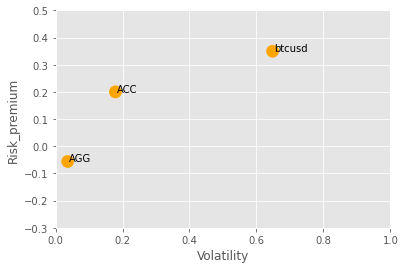

In [20]:
mean_vol_plot(risk_premiums,volatility)

In [10]:
def efficient_frontier(risk_premiums,vol,cov):
    assets = pd.DataFrame()                        
    assets['Risk_premium'] = risk_premiums
    assets['Volatility']   = vol    
    assets['Color']        = 'orange'
    assets['Size']         = 150

    all_portfolios = assets
    all_portfolios
    
   # here we are building the simulation that finds the possible portfolios
    n_portfolios = 1000

    random_arrays  = [ np.random.uniform(0,1,len(tickers)) for i in range(0,n_portfolios) ]
    random_weights = [ ra/ra.sum() for ra in random_arrays ]
    
    random = pd.DataFrame()
    random['Risk_premium'] = [ w.dot(risk_premiums)   for w in random_weights ]
    random['Volatility']   = [ w.dot(cov).dot(w)**0.5 for w in random_weights ]
    random['Color']        = 'gray'
    random['Size']         = 10
    random['sharpe']       = random['Risk_premium']/random['Volatility']

    all_portfolios = pd.concat([random, assets])
    
    graph = all_portfolios.plot.scatter('Volatility','Risk_premium', color=all_portfolios.Color, s=all_portfolios.Size, xlim=(0,1), ylim=(-0.03,0.5))

    # add ticker to plot:
    for s in tickers:                                 # loop over sectors
        x = all_portfolios.loc[s,'Volatility']+0.005  # get x-coordinate from table (+ offset so the labels don't overlap with points)
        y = all_portfolios.loc[s,'Risk_premium']      # get y-coordinate from table
        graph.text(x,y,s)                             # add the ticker symbol to the graph
    return graph

<AxesSubplot:xlabel='Volatility', ylabel='Risk_premium'>

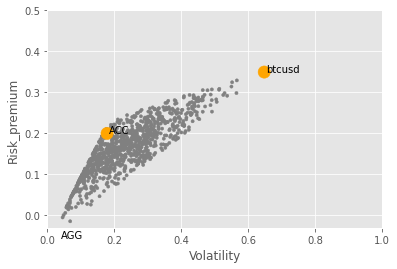

In [11]:
efficient_frontier(risk_premiums,volatility,covariance)

In [12]:
def max_sharpe_weights(risk_premiums,vol,cov):
    #we have to do the simulation again, I'm sure this could also be done with a nested function but that's ok
    assets = pd.DataFrame()                        
    assets['Risk_premium'] = risk_premiums
    assets['Volatility']   = vol    
    assets['Color']        = 'orange'
    assets['Size']         = 150

    all_portfolios = assets
    all_portfolios
    
    n_portfolios = 1000

    random_arrays  = [ np.random.uniform(0,1,len(tickers)) for i in range(0,n_portfolios) ]
    random_weights = [ ra/ra.sum() for ra in random_arrays ]
    
    random = pd.DataFrame()
    random['Risk_premium'] = [ w.dot(risk_premiums)   for w in random_weights ]
    random['Volatility']   = [ w.dot(cov).dot(w)**0.5 for w in random_weights ]
    random['Color']        = 'gray'
    random['Size']         = 10
    random['sharpe']       = random['Risk_premium']/random['Volatility']

    all_portfolios = pd.concat([random, assets])
    
    #now we have to do some crazy stuff, basically I am creating a data frame where all of the entries 
    #are themselves lists of possible weights
    #I am going to parse through the dataframe to find the weights that correspond to the maximum sharpe ratio
    random['weights'] = random_weights
    wgts = random[(random['sharpe'] >= random.sharpe.max())].weights.astype(str)

    rp = random[(random['sharpe'] == random.sharpe.max())].Risk_premium
    #now I have found the weights, but they are in string form. We want them to be a panda series
    #here i am turning the string weights into a list
    lw = list(wgts)
    #finding the first entry in the list(the first entry is always a quote)
    ws = str(lw[0])
    # replacing the quote with a blank
    ws = ws.replace('[','')
    ws = ws.replace(']','')
    #deliniating the list values by spaces
    lw = ws.split(' ')
    #filtering out the bad data
    lw = list(filter(None, lw))
    #Finally turning the list into a numpy array
    nw = np.array(lw)
    nw = nw.astype(float)
    
    #now we have to turn the numpy array into a panda series 
    
    sharpe_weights                  = pd.DataFrame()
    sharpe_weights['Risk_Premiums'] = risk_premiums
    sharpe_weights['Weights']       = nw
    sharpe_weights['weighted_ret']  = sharpe_weights['Weights']*sharpe_weights['Risk_Premiums']
    
    return sharpe_weights

#don't forget to turn this into a variable when you run the function!


In [13]:
sharpe_weights = max_sharpe_weights(risk_premiums, volatility, covariance)
sharpe_weights

,Risk_Premiums,Weights,weighted_ret
AGG,-0.055910,0.005014,-0.000280
ACC,0.200038,0.907829,0.181601
btcusd,0.349611,0.087157,0.030471


In [14]:
def max_sharpe_stats(risk_premiums,vol,cov,sharpe_weights,r):
    #we have to do the simulation again, I'm sure this could also be done with a nested function but that's ok
    assets = pd.DataFrame()                        
    assets['Risk_premium'] = risk_premiums
    assets['Volatility']   = vol    
    assets['Color']        = 'orange'
    assets['Size']         = 150

    all_portfolios = assets
    all_portfolios
    
    n_portfolios = 1000

    random_arrays  = [ np.random.uniform(0,1,len(tickers)) for i in range(0,n_portfolios) ]
    random_weights = [ ra/ra.sum() for ra in random_arrays ]
    
    random = pd.DataFrame()
    random['Risk_premium'] = [ w.dot(risk_premiums)   for w in random_weights ]
    random['Volatility']   = [ w.dot(cov).dot(w)**0.5 for w in random_weights ]
    random['Color']        = 'gray'
    random['Size']         = 10
    random['sharpe']       = random['Risk_premium']/random['Volatility']

    all_portfolios = pd.concat([random, assets])
    
    #find the maximum sharpe ratio from the data
    max_sharpe = random[(random['Risk_premium']>= 0)][(random['Volatility']<= 1)].sharpe.max()
    
    #find the volatility
    r              = r.dot(sharpe_weights['Weights'])
    r['total_ret'] = r.sum()
    
    total          = r['total_ret']
    rf             = 0.011
    erp            = total.mean() * 252 - rf       
    volatility     = total.std()  * 252**0.5
   
  
    
    
    

In [15]:
max_sharpe_stats(risk_premiums,volatility,covariance,sharpe_weights,r)

<ipython-input-14-5cb3a0d65b5c>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  max_sharpe = random[(random['Risk_premium']>= 0)][(random['Volatility']<= 1)].sharpe.max()
